# Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [2]:
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid

from grr.Simulation import GIFnet_Simulation
from grr.Tools import PSTH

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex = False)
IMG_PATH = os.path.join('figs', 'ims', 'GIF_network')

# Load data

Put `GIFnet_Simulation` objects into a DataFrame with columns to describe experimental conditions.

In [4]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network')

sim_dict = {'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

for directory in ['subsample_base', 'subsample_noIA', 'subsample_fixedIA']:
    for fname in os.listdir(os.path.join(DATA_PATH, directory)):
        if (fname.endswith('hdf5') or fname.endswith('h5')) and 'impulse' in fname:
        
            if 'base' in fname:
                sim_dict['Mod type'].append('Base')
            elif 'noIA' in fname:
                sim_dict['Mod type'].append('No IA')
            elif 'fixedIA' in fname:
                sim_dict['Mod type'].append('Fixed IA')
            else:
                sim_dict['Mod type'].append('Unknown')

            if 'noGABA' in fname:
                sim_dict['Condition'].append('No GABA')
            elif 'GABA' in fname:
                sim_dict['Condition'].append('Control')
            else:
                sim_dict['Condition'].append('Unknown')

            sim_dict['Rep'].append(
                int(re.search(r'rep([0-9]+)', fname).groups()[-1])
            )

            sim_dict['Model'].append(GIFnet_Simulation(os.path.join(DATA_PATH, directory, fname), mode = 'r'))

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Condition,Mod type,Model,Rep
0,Control,Base,"[connectivity_matrix, gaba, ser]",0
1,Control,Base,"[connectivity_matrix, gaba, ser]",1
2,Control,Base,"[connectivity_matrix, gaba, ser]",2
3,Control,Base,"[connectivity_matrix, gaba, ser]",3
4,Control,Base,"[connectivity_matrix, gaba, ser]",4


In [5]:
(sim_df['Model'][0])

<HDF5 file "base_impulse_GABA_rep0.hdf5" (mode r)>

# Analysis
## Extract PSTH

In [6]:
sim_df['5HT PSTH'] = None
sim_df['5HT PSTH'] = sim_df['5HT PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [7]:
PSTH_width = 25.

for i in range(sim_df.shape[0]):
    print('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, '5HT PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, '5HT PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] == 'No GABA':
        sim_df.loc[i, 'GABA PSTH'] = None
        continue
    else:
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )

Computing PSTH 0.0%
Computing PSTH 1.7%
Computing PSTH 3.3%
Computing PSTH 5.0%
Computing PSTH 6.7%
Computing PSTH 8.3%
Computing PSTH 10.0%
Computing PSTH 11.7%
Computing PSTH 13.3%
Computing PSTH 15.0%
Computing PSTH 16.7%
Computing PSTH 18.3%
Computing PSTH 20.0%
Computing PSTH 21.7%
Computing PSTH 23.3%
Computing PSTH 25.0%
Computing PSTH 26.7%
Computing PSTH 28.3%
Computing PSTH 30.0%
Computing PSTH 31.7%
Computing PSTH 33.3%
Computing PSTH 35.0%
Computing PSTH 36.7%
Computing PSTH 38.3%
Computing PSTH 40.0%
Computing PSTH 41.7%
Computing PSTH 43.3%
Computing PSTH 45.0%
Computing PSTH 46.7%
Computing PSTH 48.3%
Computing PSTH 50.0%
Computing PSTH 51.7%
Computing PSTH 53.3%
Computing PSTH 55.0%
Computing PSTH 56.7%
Computing PSTH 58.3%
Computing PSTH 60.0%
Computing PSTH 61.7%
Computing PSTH 63.3%
Computing PSTH 65.0%
Computing PSTH 66.7%
Computing PSTH 68.3%
Computing PSTH 70.0%
Computing PSTH 71.7%
Computing PSTH 73.3%
Computing PSTH 75.0%
Computing PSTH 76.7%
Computing PSTH 78.3

In [8]:
psth_dict = {'Mod type': [], 'Condition': [], '5HT PSTH': []}
for modtype in sim_df['Mod type'].unique():
    for cond in sim_df['Condition'].unique():
        psth_dict['Mod type'].append(modtype)
        psth_dict['Condition'].append(cond)
        psth_dict['5HT PSTH'].append(np.array(
            sim_df.loc[(sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), '5HT PSTH'].tolist()
        ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [9]:
psth_df.head()

,5HT PSTH,Condition,Mod type
0,"[[[0.13333333333333333, 0.13333333333333333, 0...",Control,Base
1,"[[[0.4666666666666667, 0.4666666666666667, 0.4...",No GABA,Base
2,"[[[0.26666666666666666, 0.26666666666666666, 0...",Control,Fixed IA
3,"[[[0.13333333333333333, 0.13333333333333333, 0...",No GABA,Fixed IA
4,"[[[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4...",Control,No IA


In [11]:
psth_df['5HT PSTH'][0].shape

(10, 15, 20000)

Each 5HT PSTH has dimensionality `[repeats, sweeps, time]`.

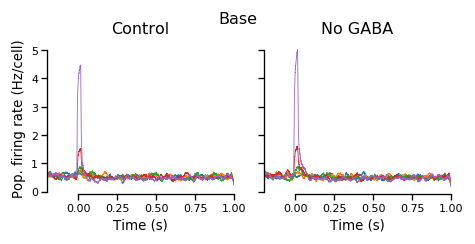

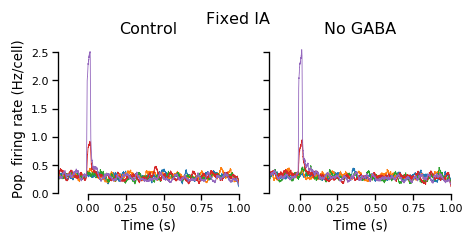

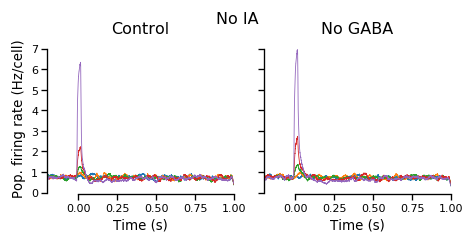

In [16]:
def select_PSTH_dataset(dframe, condition, mod_type, psth_type='5HT PSTH'):
    return dframe.loc[(dframe['Condition'] == condition) & (dframe['Mod type'] == mod_type), psth_type].item()

t_vec = np.arange(0, sim_df.loc[0, 'Model'].attrs['T'], sim_df.loc[0, 'Model'].attrs['dt']) * 1e-3 - 1
for modtype in psth_df['Mod type'].unique():
    fig, ax = plt.subplots(1, len(sim_df['Condition'].unique()), sharey=True, figsize=(4, 2))
    ax[0].set_ylabel('Pop. firing rate (Hz/cell)')
    
    plt.suptitle(modtype)
    for i, cond in enumerate(psth_df['Condition'].unique()):
        ax[i].set_title(cond)
        ax[i].plot(
            t_vec,
            select_PSTH_dataset(psth_df, cond, modtype).mean(axis=0).T[:, 10:15],
        )
        ax[i].set_xlim(-0.2, 1)
        ax[i].set_xlabel('Time (s)')
        
    sns.despine(trim=True)
    
    plt.tight_layout()
    
    if IMG_PATH is not None:
        plt.savefig(
            os.path.join(IMG_PATH, '5HT_PSTH_{}_{}.png'.format(modtype, cond))
        )
    plt.show()

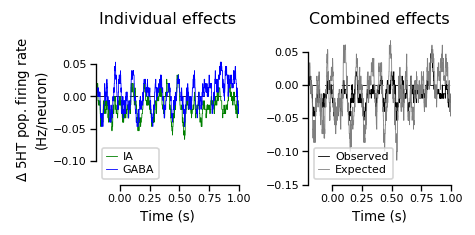

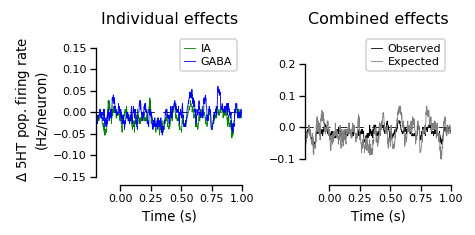

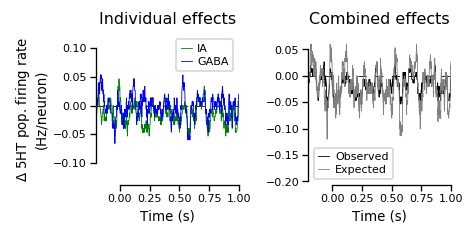

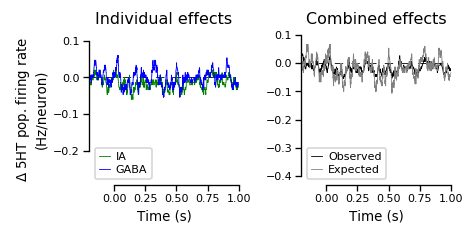

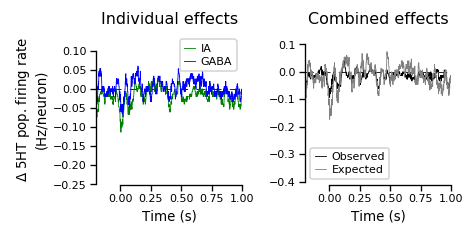

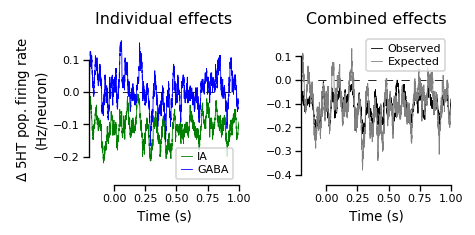

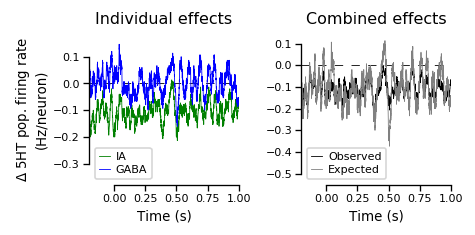

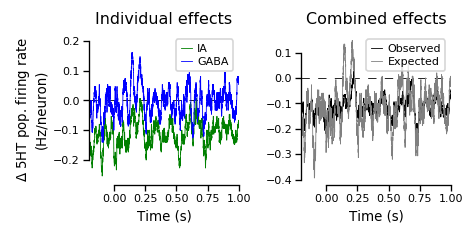

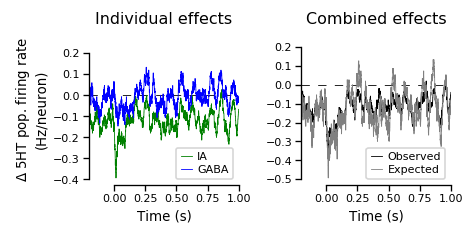

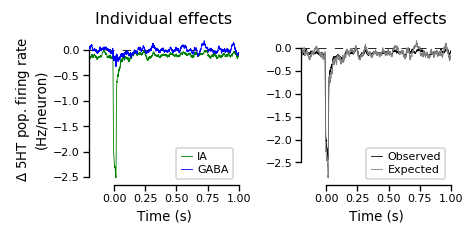

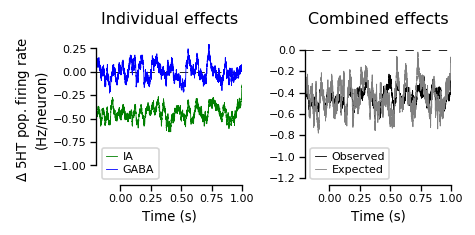

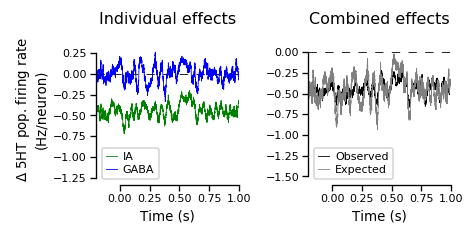

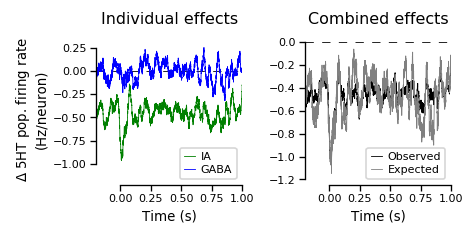

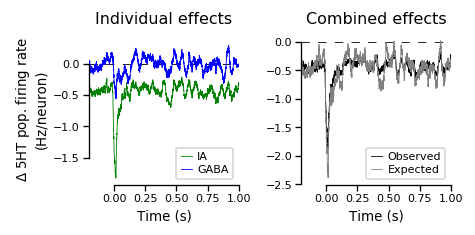

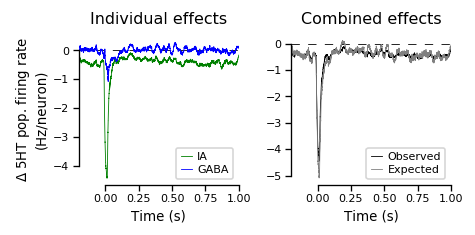

In [17]:
for sweep_no in range(sim_dict['Model'][0].get_no_sweeps()):
    IA_contrast = (select_PSTH_dataset(psth_df, 'No GABA', 'Fixed IA') 
                   - select_PSTH_dataset(psth_df, 'No GABA', 'No IA')).mean(axis=0).T[:, sweep_no]
    GABA_contrast = (select_PSTH_dataset(psth_df, 'Control', 'No IA') 
                     - select_PSTH_dataset(psth_df, 'No GABA', 'No IA')).mean(axis=0).T[:, sweep_no]
    double_contrast = (select_PSTH_dataset(psth_df, 'Control', 'Fixed IA') 
                       - select_PSTH_dataset(psth_df, 'No GABA', 'No IA')).mean(axis=0).T[:, sweep_no]

    plt.figure(figsize=(4, 2))

    plt.subplot(121)
    plt.title('Individual effects')
    plt.axhline(0, ls='--', dashes=(10, 10), lw=0.5, color='k')
    plt.plot(t_vec, IA_contrast, color='green', label='IA')
    plt.plot(t_vec, GABA_contrast, color='blue', label='GABA')
    plt.xlim(-0.2, 1)
    plt.ylabel('$\\Delta$ 5HT pop. firing rate\n(Hz/neuron)')
    plt.xlabel('Time (s)')
    plt.legend()

    plt.subplot(122)
    plt.title('Combined effects')
    plt.axhline(0, ls='--', dashes=(10, 10), lw=0.5, color='k')
    plt.plot(t_vec, double_contrast, 'k-', label='Observed')
    plt.plot(t_vec, IA_contrast + GABA_contrast, color='gray', label='Expected')
    plt.xlim(-0.2, 1)
    plt.xlabel('Time (s)')
    plt.legend()

    sns.despine(trim=True)

    plt.tight_layout()
    if IMG_PATH is not None:
        plt.savefig(
            os.path.join(IMG_PATH, 'contrasts_sweep_{}.png'.format(sweep_no))
        )
    plt.show()

# Get pointwise gain

In [18]:
def time_to_index(time_, dt):
    return int(time_ / dt)

def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = time_to_index(step_start_time, 0.1)
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., 10000:].mean(axis=2).mean(axis=1) - baseline

step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)   

In [19]:
def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, dt=0.1):
    """
    Returns
    -------
    (gain, intercept)
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = time_to_index(step_start_time, dt)
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., time_to_index(baseline_start_time, dt):step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1)
    
    return coeffs[0, :], coeffs[1, :]

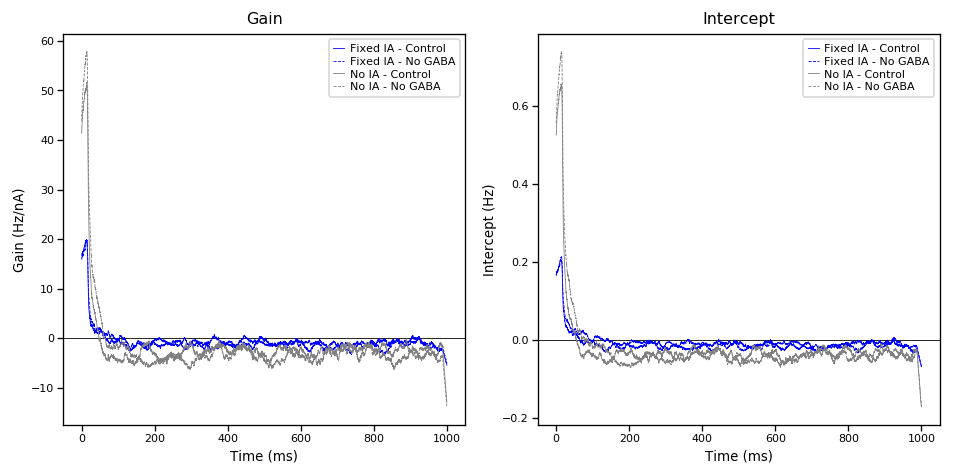

In [21]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.title('Gain')
plt.axhline(0, color='k')
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'Control', 'Fixed IA'),
        step_amplitudes,
        500.,
        1000.
    )[0],
    'b-',
    label='Fixed IA - Control'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'No GABA', 'Fixed IA'),
        step_amplitudes,
        500.,
        1000.
    )[0],
    'b--',
    label='Fixed IA - No GABA'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'Control', 'No IA'),
        step_amplitudes,
        500.,
        1000.
    )[0],
    color='gray',
    label='No IA - Control'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'No GABA', 'No IA'),
        step_amplitudes,
        500.,
        1000.
    )[0],
    '--', color='gray',
    label='No IA - No GABA'
)
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')

plt.subplot(122)
plt.title('Intercept')
plt.axhline(0, color='k')
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'Control', 'Fixed IA'),
        step_amplitudes,
        500.,
        1000.
    )[1],
    'b-',
    label='Fixed IA - Control'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'No GABA', 'Fixed IA'),
        step_amplitudes,
        500.,
        1000.
    )[1],
    'b--',
    label='Fixed IA - No GABA'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'Control', 'No IA'),
        step_amplitudes,
        500.,
        1000.
    )[1],
    color='gray',
    label='No IA - Control'
)
plt.plot(
    np.arange(0, 1000, 0.1),
    get_pointwise_gain(
        select_PSTH_dataset(psth_df, 'No GABA', 'No IA'),
        step_amplitudes,
        500.,
        1000.
    )[1],
    '--', color='gray',
    label='No IA - No GABA'
)
plt.legend()
plt.ylabel('Intercept (Hz)')
plt.xlabel('Time (ms)')

plt.tight_layout()
if IMG_PATH is not None:
        plt.savefig(
            os.path.join(IMG_PATH, 'impulse_response_filter.png')
        )
plt.show()

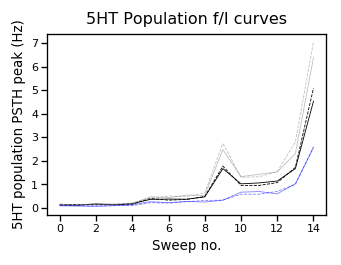

In [22]:
time_slice = slice(10000, 12000)

fig, ax = plt.subplots(1, 1)

ax.set_title('5HT Population f/I curves')
ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'Control') & (psth_df['Mod type'] == 'Base'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    'k-',
    label='Base CTRL'
)
ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'No GABA') & (psth_df['Mod type'] == 'Base'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    'k--',
    label='Base no GABA'
)

ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'Control') & (psth_df['Mod type'] == 'No IA'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    '-', color='gray', alpha=0.5,
    label='IA KO CTRL'
)
ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'No GABA') & (psth_df['Mod type'] == 'No IA'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    '--', color='gray', alpha=0.5,
    label='IA KO no GABA'
)

ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'Control') & (psth_df['Mod type'] == 'Fixed IA'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    'b-', alpha=0.5,
    label='Fixed IA CTRL'
)
ax.plot(
    psth_df.loc[
        (psth_df['Condition'] == 'No GABA') & (psth_df['Mod type'] == 'Fixed IA'), '5HT PSTH'
    ].item()[..., time_slice].max(axis=2).mean(axis=0),
    'b--', alpha=0.5,
    label='Fixed IA no GABA'
)
ax.set_ylabel('5HT population PSTH peak (Hz)')
ax.set_xlabel('Sweep no.')

plt.show()

In [11]:
arrs = []
for condition in psth_df['Condition'].unique():
    for modtype in psth_df['Mod type'].unique():
        arr = psth_df.loc[
            (psth_df['Condition'] == condition) & (psth_df['Mod type'] == modtype), '5HT PSTH'
        ].item()[..., time_slice].max(axis=2).astype(object)
        arrs.append(np.concatenate(
            [np.array([condition for i in range(arr.size)])[:, np.newaxis],  # Condition column
            np.array([modtype for i in range(arr.size)])[:, np.newaxis],    # Model type column
            np.array([i % arr.shape[0] for i in range(arr.size)])[:, np.newaxis],  # Sweep no. column
            arr.flatten()[:, np.newaxis]],
            axis=1
        ))

arrs = np.concatenate(arrs, axis=0)
peak_df = pd.DataFrame(arrs, columns=['Condition', 'Mod type', 'Sweep', 'PSTH peak']).infer_objects()
peak_df.head()

,Condition,Mod type,Sweep,PSTH peak
0,Control,Base,0,0.533333
1,Control,Base,1,0.333333
2,Control,Base,2,0.400000
3,Control,Base,3,0.400000
4,Control,Base,4,0.333333


/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


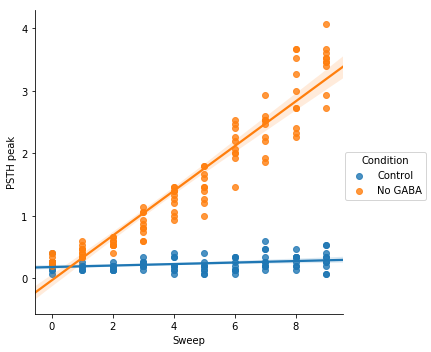

In [12]:
sns.lmplot('Sweep', 'PSTH peak', hue='Condition', data = peak_df.loc[peak_df['Mod type'] == 'Fixed IA', :])

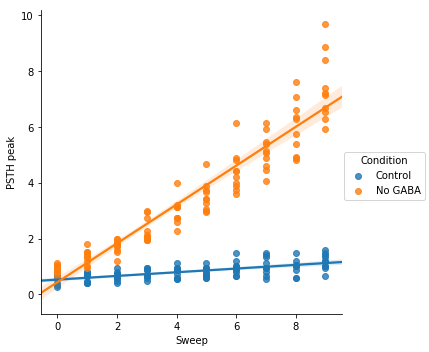

In [13]:
sns.lmplot('Sweep', 'PSTH peak', hue='Condition', data = peak_df.loc[peak_df['Mod type'] == 'No IA', :])

In [ ]:
peak_df.to_csv('PSTH_peak.csv')

Analyse dataframe in r

# Illustrate PSTH

Sample trace from a 5HT cell.

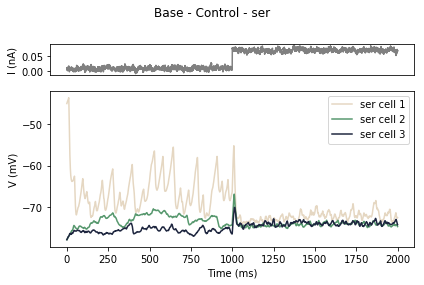

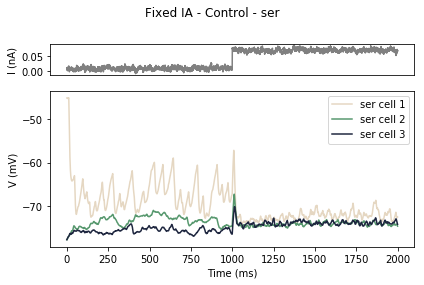

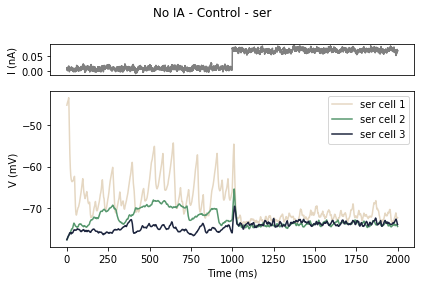

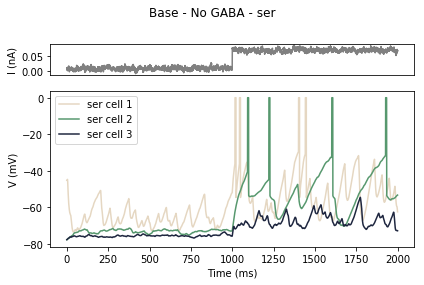

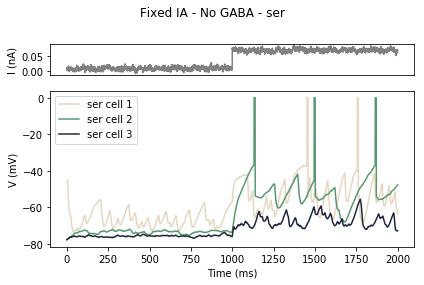

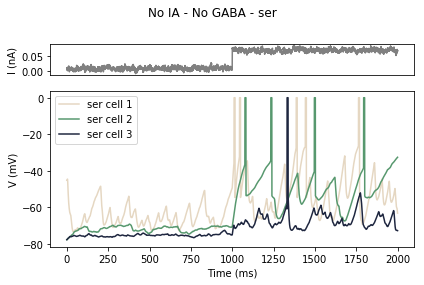

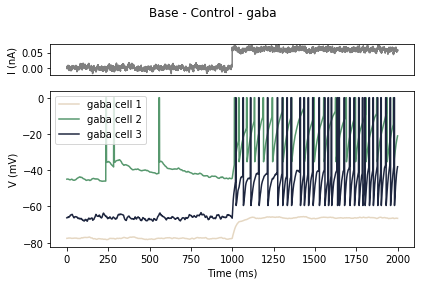

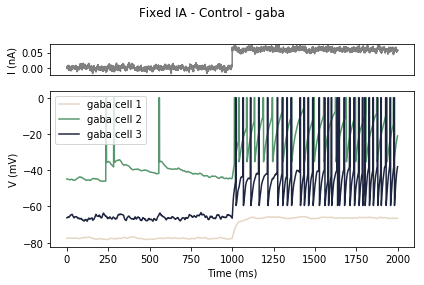

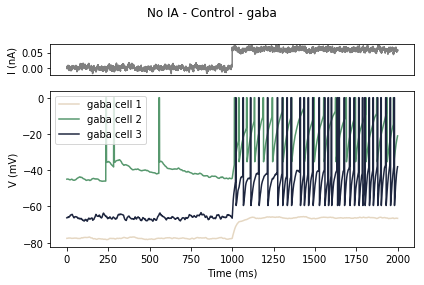

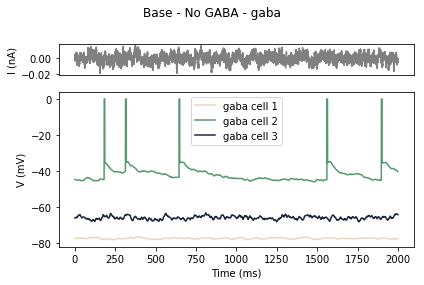

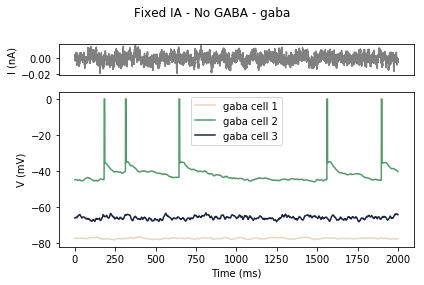

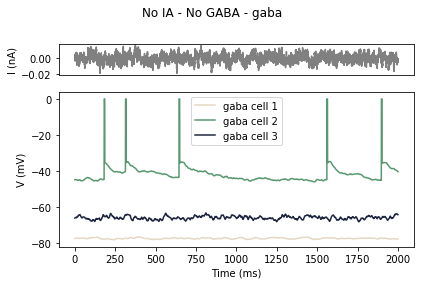

In [14]:
ex_rep_no = 5
no_cells = 3

cmap = sns.cubehelix_palette(3, start=.2, rot=-.75)
sample_tr_spec = gs.GridSpec(2, 1, height_ratios=[0.2, 1])

for plot_selection in ParameterGrid({
    'Mod type': sim_df['Mod type'].unique(), 
    'Condition': sim_df['Condition'].unique(),
    'Cell type': ['ser', 'gaba']
}):
    # Get sample traces to plot.
    tmp_ex_mod = sim_df.loc[
        (
            (sim_df['Mod type'] == plot_selection['Mod type'])
            & (sim_df['Condition'] == plot_selection['Condition'])
            & (sim_df['Rep'] == ex_rep_no)
        ), 
        'Model'
    ].iat[0]
    
    t_vec = np.arange(0, tmp_ex_mod.attrs['T'], tmp_ex_mod.attrs['dt'])
    
    # Generate figure.
    plt.figure()
    
    plt.suptitle(' - '.join(
        [plot_selection['Mod type'], 
        plot_selection['Condition'], 
        plot_selection['Cell type']]
    ))

    plt.subplot(sample_tr_spec[0, :])
    plt.plot(
        t_vec, 
        tmp_ex_mod[plot_selection['Cell type']]['examples']['I'][sweep_no, 0, :], 
        color='gray'
    )
    plt.xticks([])
    plt.ylabel('I (nA)')

    plt.subplot(sample_tr_spec[1, :])
    for i in range(no_cells):
        plt.plot(
            t_vec, 
            tmp_ex_mod[plot_selection['Cell type']]['examples']['V'][sweep_no, i, :].T, 
            color=cmap[i], 
            label='{} cell {}'.format(plot_selection['Cell type'], i+1)
        )
    plt.legend()
    plt.ylabel('V (mV)')
    plt.xlabel('Time (ms)')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    plt.show()
    
del tmp_ex_mod, plot_selection

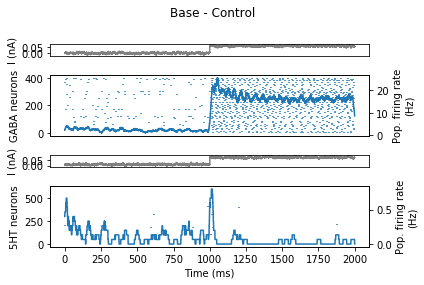

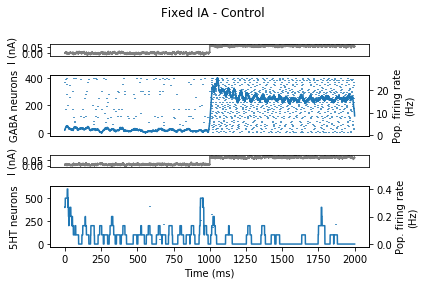

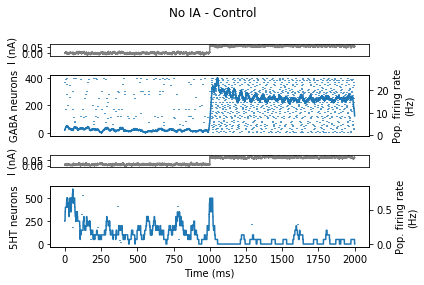

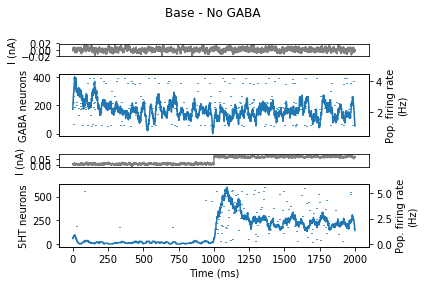

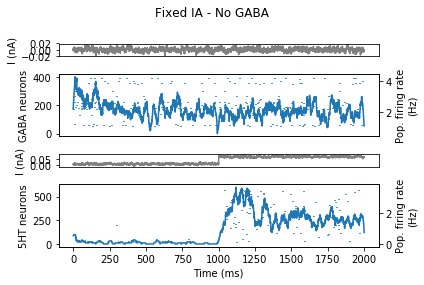

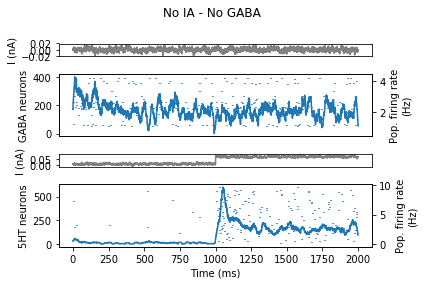

In [15]:
for plot_selection in ParameterGrid({
    'Mod type': sim_df['Mod type'].unique(), 
    'Condition': sim_df['Condition'].unique(),
}):
    # Get sample traces to plot.
    tmp_ex_mod = sim_df.loc[
        (
            (sim_df['Mod type'] == plot_selection['Mod type'])
            & (sim_df['Condition'] == plot_selection['Condition'])
            & (sim_df['Rep'] == ex_rep_no)
        ), 
        'Model'
    ].iat[0]
    
    t_vec = np.arange(0, tmp_ex_mod.attrs['T'], tmp_ex_mod.attrs['dt'])

    # Generate plot.
    plt.figure()
    
    plt.suptitle(' - '.join(
        [plot_selection['Mod type'], 
        plot_selection['Condition']]
    ))

    sample_network_spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.2, 1])

    plt.subplot(sample_network_spec[0, :])
    plt.plot(t_vec, tmp_ex_mod['gaba']['examples']['I'][sweep_no, 0, :], color='gray')
    xlims = plt.xlim()
    plt.xticks([])
    plt.ylabel('I (nA)')

    gaba_ax = plt.subplot(sample_network_spec[1, :])
    plt.eventplot(tmp_ex_mod.get_gaba_spktimes()[sweep_no])
    plt.xlim(xlims)
    plt.ylabel('GABA neurons')
    plt.xticks([])

    gaba_psth_ax = gaba_ax.twinx()
    gaba_psth_ax.plot(
        t_vec,
        PSTH(
            tmp_ex_mod.gaba_spktrains[sweep_no, ...].sum(axis=0), 
            PSTH_width, 
            tmp_ex_mod.get_no_gaba_neurons()
        )
    )
    gaba_psth_ax.set_ylabel('Pop. firing rate\n(Hz)')
    
    plt.subplot(sample_network_spec[2, :])
    plt.plot(t_vec, tmp_ex_mod['ser']['examples']['I'][sweep_no, 0, :], color='gray')
    xlims = plt.xlim()
    plt.xticks([])
    plt.ylabel('I (nA)')

    ser_ax = plt.subplot(sample_network_spec[3, :])
    plt.eventplot(tmp_ex_mod.get_ser_spktimes()[sweep_no])
    plt.xlim(xlims)
    plt.ylabel('5HT neurons')
    plt.xlabel('Time (ms)')

    ser_psth_ax = ser_ax.twinx()
    ser_psth_ax.plot(
        t_vec,
        PSTH(
            tmp_ex_mod.ser_spktrains[sweep_no, ...].sum(axis=0), 
            PSTH_width, 
            tmp_ex_mod.get_no_ser_neurons()
        )
    )
    ser_psth_ax.set_ylabel('Pop. firing rate\n(Hz)')

    plt.tight_layout()
    
    plt.subplots_adjust(top=0.85)
    plt.show()

del tmp_ex_mod, plot_selection

## Plot I/O curves

In [ ]:
def keyfilt_generator(dict_, prefix=None, model=None, baseline=None, gaba=None, rep=None):
    """Restrict _ delimited keys to specified values, or any for None."""
    for key in dict_:
        
        splitkey = key.split('_')
        assert len(splitkey) == 5, 'Expected {} to have 5 `_`-delimited entries, not {}'.format(key, len(splitkey))
        
        rejectkey = False
        for keyitem, filt in zip(splitkey, [prefix, model, baseline, gaba, rep]):
            if filt is None or keyitem in filt:
                continue
            else:
                rejectkey = True
                break
                
        if rejectkey:
            continue
        else:
            yield dict_[key]
        

In [ ]:
def condname(prefix, model, baseline, gaba, rep):
    """Throwaway function to build keys in a consistent way.
    """
    return '_'.join([prefix, model, baseline, gaba, rep])

In [ ]:
time_slice = slice(9500, 11000)

plt.figure(figsize = (10, 8))

axes = {}
spec_outer = gs.GridSpec(3, 2)

# Column 1: base model
axes['base_ser_psth'] = plt.subplot(spec_outer[0, 0])
axes['base_ser_psth'].set_title('Base')
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    axes['base_ser_psth'].plot(dat[::2, time_slice].T, 'b--')
    break  # Hacky way to plot only one example replicate.
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['ng'], None):
    axes['base_ser_psth'].plot(dat[::2, time_slice].T, 'k-')
    break
axes['base_ser_psth'].set_xticks([])
axes['base_ser_psth'].set_ylabel('5HT pop. firing rate\n(Hz/neuron)')

axes['base_gaba_psth'] = plt.subplot(spec_outer[1, 0])
for dat in keyfilt_generator(gaba_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    axes['base_gaba_psth'].plot(dat[::2, time_slice].T, 'b-')
    break
axes['base_gaba_psth'].set_ylabel('GABA pop. firing rate\n(Hz/neuron)')
axes['base_gaba_psth'].set_xlabel('Time (timesteps)')

axes['base_peak'] = plt.subplot(spec_outer[2, 0])
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['ng'], None):
    if ind == 0:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'k-', label='No GABA')
    else:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'k-')
    ind += 1
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    if ind == 0:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'b-', label='Control')
    else:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'b-')
    ind += 1
axes['base_peak'].set_ylabel('Peak 5HT pop. firing rate\n(Hz/neuron)')
axes['base_peak'].set_xlabel('Stim no.')
axes['base_peak'].legend()

# Column 2: Model with IA knocked out
axes['noIA_ser_psth'] = plt.subplot(spec_outer[0, 1])
axes['noIA_ser_psth'].set_title('IA KO')
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    axes['noIA_ser_psth'].plot(dat[::2, time_slice].T, 'b--')
    break  # Hacky way to plot only one example replicate.
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['ng'], None):
    axes['noIA_ser_psth'].plot(dat[::2, time_slice].T, 'k-')
    break
axes['noIA_ser_psth'].set_xticks([])
axes['noIA_ser_psth'].set_ylabel('5HT pop. firing rate\n(Hz/neuron)')

axes['noIA_gaba_psth'] = plt.subplot(spec_outer[1, 1])
for dat in keyfilt_generator(gaba_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    axes['noIA_gaba_psth'].plot(dat[::2, time_slice].T, 'b-')
    break
axes['noIA_gaba_psth'].set_ylabel('GABA pop. firing rate\n(Hz/neuron)')
axes['noIA_gaba_psth'].set_xlabel('Time (timesteps)')

axes['noIA_peak'] = plt.subplot(spec_outer[2, 1])
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['ng'], None):
    if ind == 0:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'k-', label='No GABA')
    else:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'k-')
    ind += 1
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    if ind == 0:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'b-', label='Control')
    else:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'b-')
    ind += 1
axes['noIA_peak'].set_ylabel('Peak 5HT pop. firing rate\n(Hz/neuron)')
axes['noIA_peak'].set_xlabel('Stim no.')
axes['noIA_peak'].legend()

plt.tight_layout()
plt.show()

In [ ]:
sweep_no = 8
spktimes = {'base': {'g': [], 'ng': []}, 'noIA': {'g': [], 'ng': []}}
for mod_type in spktimes:
    for gaba_cond in spktimes[mod_type]:
        i = 0
        for dat in keyfilt_generator(simfiles, ['subsample'], [mod_type], ['m'], [gaba_cond], None):
            print 'Getting spktimes {} {} {}'.format(mod_type, gaba_cond, i)
            spktimes_tmp = dat.get_ser_spktimes()
            spktimes_sw_tmp = np.concatenate(spktimes_tmp[sweep_no])
            spktimes_sw_tmp.sort()
            spktimes[mod_type][gaba_cond].append(spktimes_sw_tmp)
            i += 1

del mod_type, gaba_cond, dat, spktimes_tmp, spktimes_sw_tmp, i

In [ ]:
start_time = 1000
stop_time = 1400

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('Base')
for spktimes_tmp in spktimes['base']['g']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='b')
for spktimes_tmp in spktimes['base']['ng']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='k')
plt.yticks([])
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylabel('Density')

plt.subplot(223)
for i, spktimes_tmp in enumerate(spktimes['base']['g']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-', label='Control'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-'
        )
for i, spktimes_tmp in enumerate(spktimes['base']['ng']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-', label='No GABA'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-'
        )
plt.ylabel('Cumulative fraction')
plt.xlabel('Time from stim onset')
plt.legend()

plt.subplot(222)
plt.title('IA KO')
for spktimes_tmp in spktimes['noIA']['g']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='b')
for spktimes_tmp in spktimes['noIA']['ng']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='k')
plt.yticks([])
plt.xscale('log')
plt.xlim(1, stop_time - start_time)

plt.subplot(224)
for i, spktimes_tmp in enumerate(spktimes['noIA']['g']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-', label='Control'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-'
        )
for i, spktimes_tmp in enumerate(spktimes['noIA']['ng']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-', label='No GABA'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-'
        )
plt.xlabel('Time from stim onset')
plt.legend()

plt.show()

del spktimes_tmp, i

Top row: KDE plots of spike time PDF for each replicate. Bottom row: cumulative spike time distribution plots for each replicate.

In [ ]:
def masked_kde(spktimes, start_time, stop_time, **pltargs):
    spktimes_tmp = np.concatenate(spktimes)
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, **pltargs)


def masked_cumdist(spktimes, start_time, stop_time, **pltargs):
    spktimes_tmp = np.concatenate(spktimes).copy()
    spktimes_tmp.sort()
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    plt.plot(
        spktimes_tmp[mask] - start_time, 
        np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
        **pltargs
    )


plt.figure(figsize=(10, 6))

plt.subplot(121)
masked_kde(spktimes['base']['g'], start_time, stop_time, color='b', label='Base model ctrl')
masked_kde(spktimes['base']['ng'], start_time, stop_time, color='k', label='Base model no GABA')
masked_kde(spktimes['noIA']['g'], start_time, stop_time, color='b', linestyle='--', label='IA KO ctrl')
masked_kde(spktimes['noIA']['ng'], start_time, stop_time, color='k', linestyle='--', label='IA KO no GABA')
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylim(0, plt.ylim()[1] * 1.2)
plt.yticks([])
plt.ylabel('Density')
plt.xlabel('Time from stim onset')
plt.legend()

plt.subplot(122)
masked_cumdist(spktimes['base']['g'], start_time, stop_time, color='b', label='Base model ctrl')
masked_cumdist(spktimes['base']['ng'], start_time, stop_time, color='k', label='Base model no GABA')
masked_cumdist(spktimes['noIA']['g'], start_time, stop_time, color='b', linestyle='--', label='IA KO ctrl')
masked_cumdist(spktimes['noIA']['ng'], start_time, stop_time, color='k', linestyle='--', label='IA KO no GABA')
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylabel('Cumulative fraction')
plt.xlabel('Time from stim onset')
plt.legend()

plt.show()

# Close all files

In [ ]:
for fname in simfiles.keys():
    simfiles[fname].close()